# Tutorial notebook to run vis_cpu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation

from hera_sim import io
from vis_cpu import conversions, simulate_vis
from pyuvsim.analyticbeam import AnalyticBeam

# Initialize UVData object

Set the antenna dictionary which contains the antenna index and co-ordinates. We also set different primary beam (PB) of each antennas using a list of UVBeam object (here Gaussian and Uniform PB are used for 2 antennas).

In [2]:
nants = 2

ants = {}
for i in range(nants):
    ants.update([(i, (-(i % 3), i, i % 4))])

#set different UVBeam for each antenna
beam = [AnalyticBeam("gaussian", sigma=0.5), AnalyticBeam("uniform")]

Set the input parameters (e.g. no. of frequencies, channel width (in Hz), start fequency (in Hz), no. of time samples, integration time (in sec), start time (in JD) ) to create a empty UVData object.

In [3]:
Nfreqs = 10
channel_width = 800000.0 # in Hz
start_freq = 100000000.0 # in Hz

Ntimes = 5 
integration_time = 40 #in sec
start_time = 2458902.4 #in JD

In [4]:
uvdata = io.empty_uvdata(
        Nfreqs = Nfreqs,             
        start_freq = start_freq,
        channel_width = channel_width,
        start_time = start_time,
        integration_time = integration_time,
        Ntimes = Ntimes,
        array_layout = ants
    )

# Initialize source parameters

Set the source parameters (total no. of point sources, ra (deg), dec (deg), flux (in Jy) and sp. index

In [5]:
nsource = 2

sources = []

ra = np.linspace(0. , 30., nsource)
dec = np.linspace(-25. , -35., nsource)

flux = np.random.random(nsource) * 4
for i in range(nsource):
    sources.append([ra[i], dec[i], flux[i], 0])
sources = np.array(sources)

In [6]:
# ra, dec in one array (rad)
ra_dec = np.deg2rad(sources[:, :2])

In [7]:
# freqs from UVData object
freqs = np.unique(uvdata.freq_array)

In [8]:
# calculate flux of all sources for frequency
flux = ((freqs[:, np.newaxis] / freqs[0]) ** sources[:, 3].T * sources[:, 2].T).T

# Correct source locations so that vis_cpu uses the right frame

Set telescope parameters (longitude (in deg), latitude (in deg), height (in meter)

In [9]:
hera_lon = 21.428305555555557
hera_lat = -30.72152777777791
hera_height = 1073.0000000093132

location = EarthLocation.from_geodetic(lat=hera_lat, lon=hera_lon, height=hera_height)

In [10]:
obstime = Time(start_time, format="jd", scale="utc")

ra_new, dec_new = conversions.equatorial_to_eci_coords(
    ra_dec[:, 0], ra_dec[:, 1], obstime, location, unit="rad", frame="icrs"
)

ra_dec = np.column_stack((ra_new, dec_new))

# Run vis_cpu

Use all the paramters above to run vis_cpu, which ouputs a complex visibility array. If `polarized = True`, the output will have shape (NAXES, NFEED, NFREQS, NTIMES, NANTS, NANTS), otherwise it will have
        shape (NFREQS, NTIMES, NANTS, NANTS)

In [11]:
# lsts from UVData object
lsts = np.unique(uvdata.lst_array)

In [12]:
# simulate visibilities 
vis_vc = simulate_vis(
        ants=ants,
        fluxes=flux,
        ra=ra_dec[:,0],
        dec=ra_dec[:,1],
        freqs=freqs,
        lsts=lsts,
        beams=beam,
        pixel_beams=False,
        polarized=False,
        precision=2,
    )

In [13]:
vis_vc.shape

(10, 5, 2, 2)

# Plot auto and cross visibilities

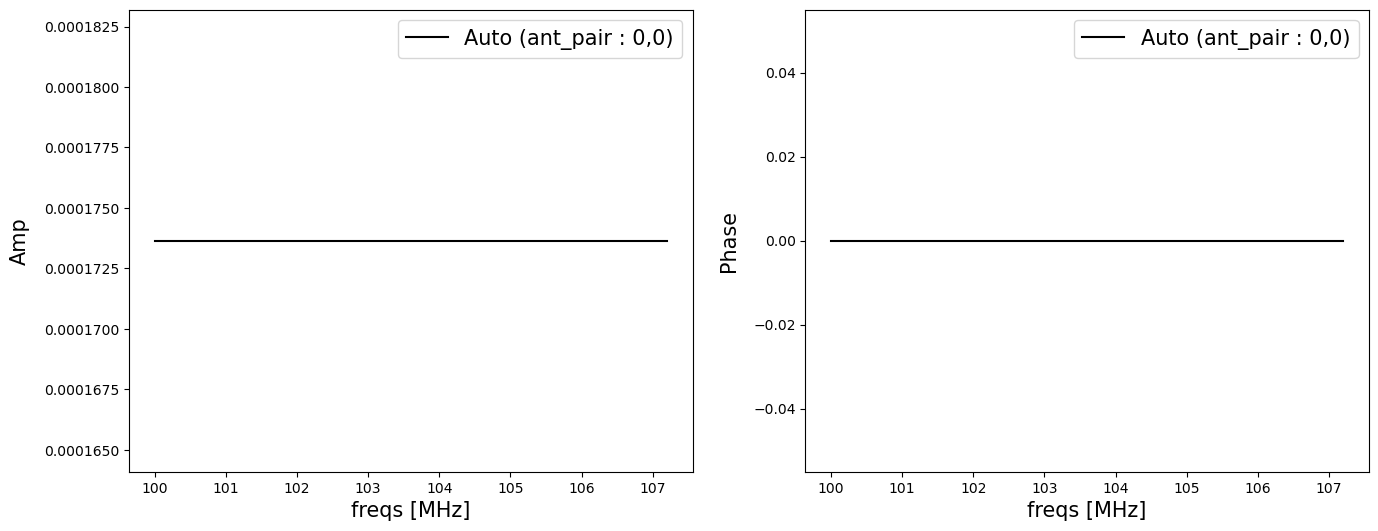

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(freqs/1.e6, np.abs(vis_vc[:,0,0,0]),'k', label=r'Auto (ant_pair : 0,0)')
ax[0].set_ylabel('Amp', fontsize=15,labelpad=10)
ax[0].set_xlabel(r'freqs [MHz]', fontsize=15)
ax[0].legend(fontsize=15)


ax[1].plot(freqs/1.e6, np.angle(vis_vc[:,0,0,0]),'k', label=r'Auto (ant_pair : 0,0)')
ax[1].set_ylabel('Phase', fontsize=15,labelpad=10)
ax[1].set_xlabel(r'freqs [MHz]', fontsize=15)
ax[1].legend(fontsize=15)

plt.show()

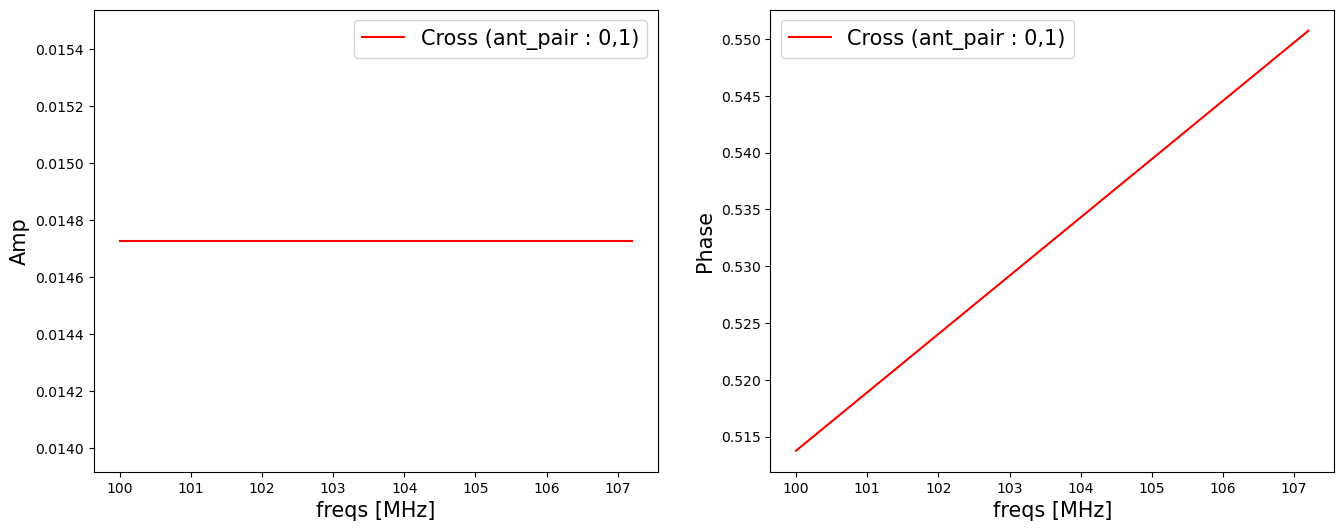

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(freqs/1.e6, np.abs(vis_vc[:,0,0,1]),'r', label=r'Cross (ant_pair : 0,1)')
ax[0].set_ylabel('Amp', fontsize=15)
ax[0].set_xlabel(r'freqs [MHz]', fontsize=15)
ax[0].legend(fontsize=15)


ax[1].plot(freqs/1.e6, np.angle(vis_vc[:,0,0,1]),'r', label=r'Cross (ant_pair : 0,1)')
ax[1].set_ylabel('Phase', fontsize=15)
ax[1].set_xlabel(r'freqs [MHz]', fontsize=15)
ax[1].legend(fontsize=15)

plt.show()